In [1]:
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting

In [2]:
crypto_ids = ['bitcoin', 'ethereum', 'tether']
prices = get_crypto_prices(crypto_ids)
print(prices)

{'bitcoin': {'usd': 29848}, 'ethereum': {'usd': 1899.92}, 'tether': {'usd': 1.0}}


In [3]:
asset_list = ['bitcoin', 'ethereum', 'tether', 'cardano']
start_date = datetime.now() - timedelta(days=30)  # 30 days ago
end_date = datetime.now()  # Now

df = get_historical_prices_for_assets(asset_list, start_date, end_date)
print(df.head())

                          bitcoin     ethereum    tether   cardano
time                                                              
2023-06-19 15:00:00  26415.227947  1719.280594  0.999293  0.258739
2023-06-19 16:00:00  26436.939368  1720.266843  0.999517  0.259425
2023-06-19 17:00:00  26487.164033  1716.178237  0.999943  0.258752
2023-06-19 18:00:00  26651.618782  1728.951134  0.999886  0.259846
2023-06-19 19:00:00  26822.677887  1732.217606  1.000713  0.261881


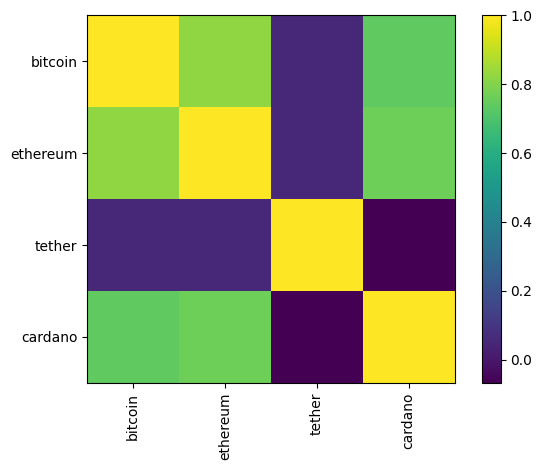

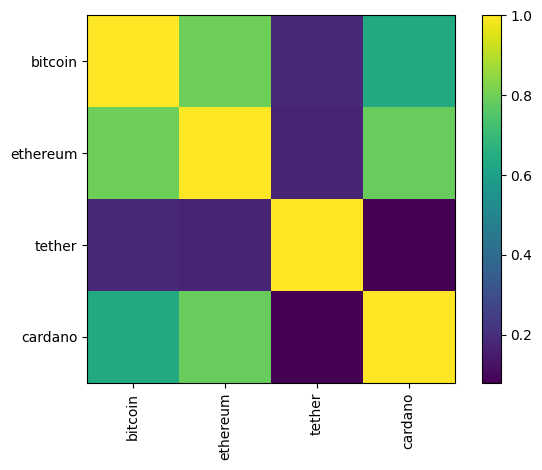

In [4]:
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

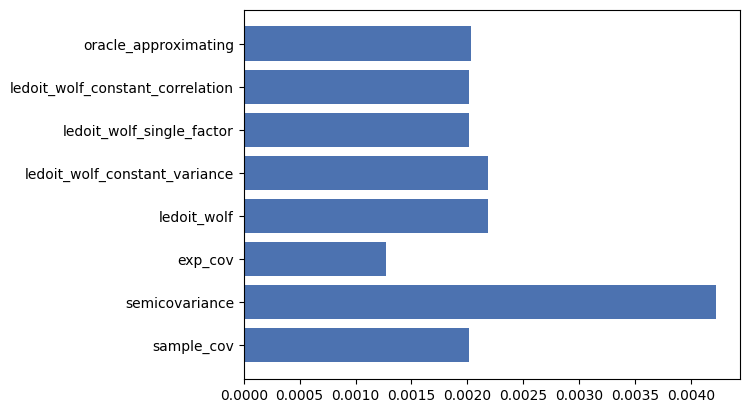

In [5]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

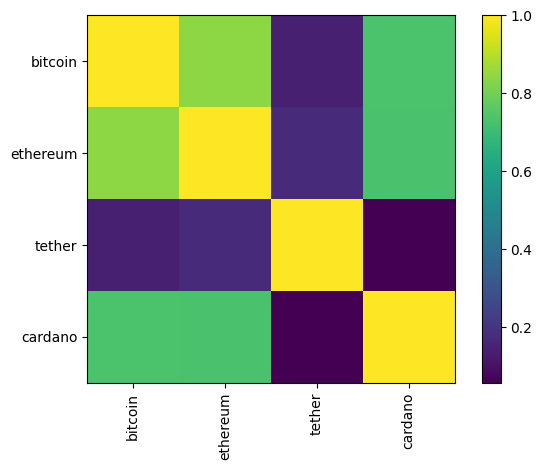

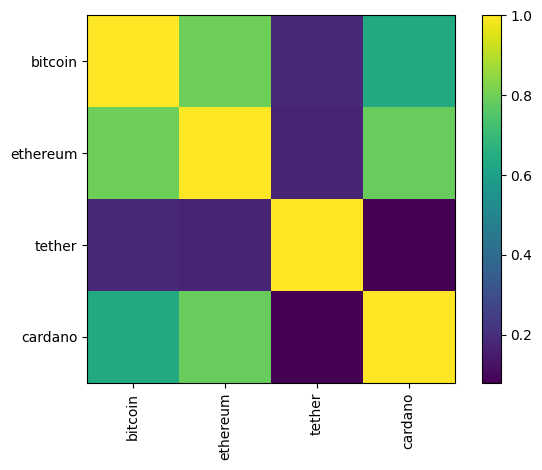

In [6]:
exp_cov = risk_models.exp_cov(past_df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

Returns

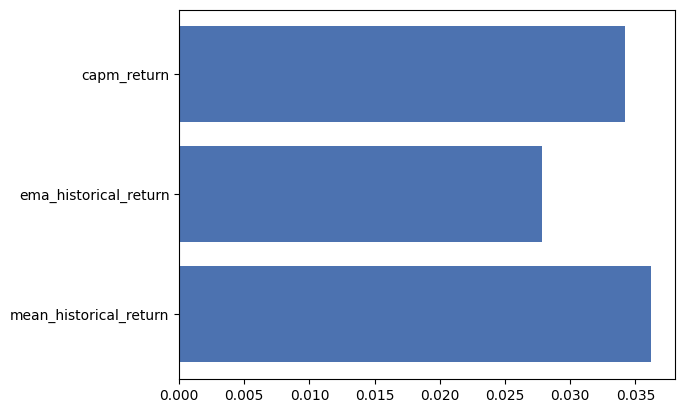

In [7]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

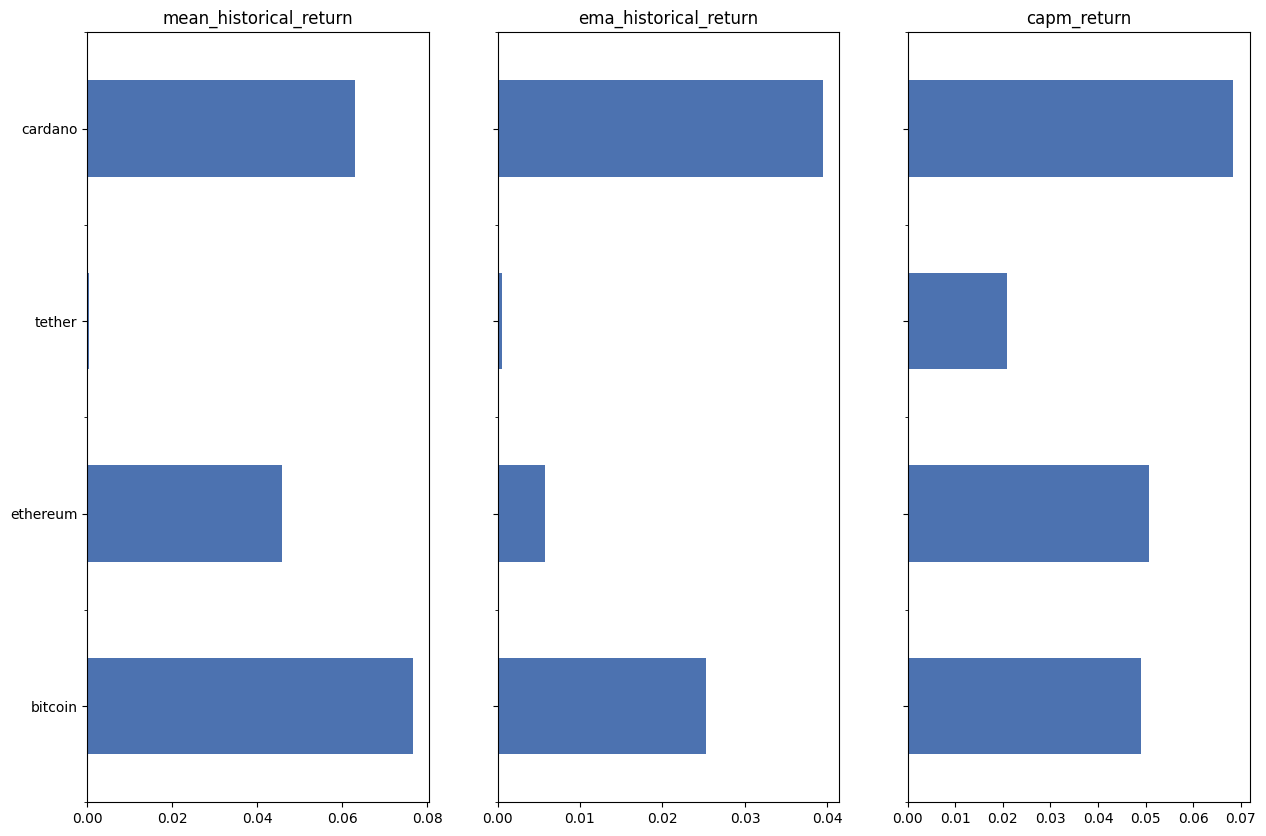

In [8]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])